## Introduction  
In this lab, we would like to make an XGBoost model to study the e-commerce behavior from a multi-category store. First, we need to download the data to your local machine, then we will load the data into a Pandas DataFrame.

## Objectives
- Apply XGBoost to an example

## Instruction
* Accept the Kaggle policy and download the data from [Kaggle](https://www.kaggle.com/code/tshephisho/ecommerce-behaviour-using-xgboost/data)
* For the first model you will only use the 2019-Nov csv data (which is still around ~2gb zipped)

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime

In [2]:
# fill this in with your path (absolute path works as well)
path_to_file = "2019-Nov.csv "
df = pd.read_csv(path_to_file)

Start with some exploratory analysis. First, take a look at the first five rows of the DataFrame. Then get the information about the DataFrame, what is the shape of the DataFrame, and what are the coumn names?

In [3]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [4]:
df.shape

(67501979, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ GB


In [6]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

# Know your Customers
How many unique customers visit the site? Assign the number of visitors to the visitor variable and print it out

In [7]:
visitor = df['user_id'].nunique()
print(f'There are {visitor} unique customer visits to the site')

There are 3696117 unique customer visits to the site


# Visitors Daily Trend
Does traffic fluctuate by date? Try using the `event_time` and `user_id` to see traffic. First you need to select by `event_time` and `user_id`, then you will `drop_duplicates` and `groupby` `event_time` and `user_id`.

In [8]:
d = df.loc[:, ["event_time", "user_id"]]
d["event_time"] = d["event_time"].apply(lambda s: str(s)[0:10])
visitor_by_date = (
    d.drop_duplicates()
    .groupby(["event_time"])["user_id"]
    .agg(["count"])
    .sort_values(by=["event_time"], ascending=True)
)
x = pd.Series(visitor_by_date.index.values).apply(
    lambda s: datetime.strptime(s, "%Y-%m-%d").date()
)
y = visitor_by_date["count"]

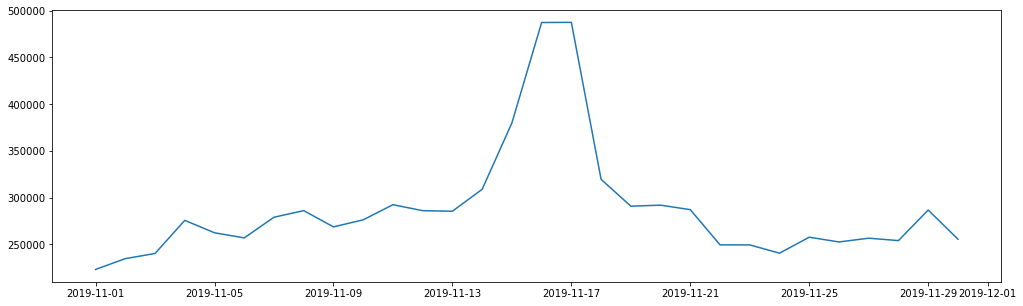

In [9]:
plt.rcParams["figure.figsize"] = (17, 5)
plt.plot(x, y)
plt.show()

### By Category and Product
Which category do customers interact with the most? What brand do they view the most? You can choose just the categories with at least 30 records in order to construct the plots.

In [10]:
max_category_num = 30
top_category = (
    df.loc[:, "category_code"]
    .value_counts()[:max_category_num]
    .sort_values(ascending=False)
)

In [11]:
top_category

electronics.smartphone               16375000
electronics.video.tv                  2208046
computers.notebook                    2180554
electronics.clocks                    2086966
apparel.shoes                         1886890
electronics.audio.headphone           1816877
appliances.environment.vacuum         1528058
appliances.kitchen.refrigerators      1427162
appliances.kitchen.washer             1403866
computers.desktop                      690502
furniture.living_room.cabinet          551642
furniture.bedroom.bed                  532673
electronics.tablet                     492497
apparel.shoes.keds                     485802
auto.accessories.player                473098
furniture.living_room.sofa             425511
construction.tools.drill               397860
appliances.kitchen.oven                379338
kids.carriage                          347476
electronics.telephone                  346800
appliances.kitchen.blender             335190
electronics.audio.subwoofer       

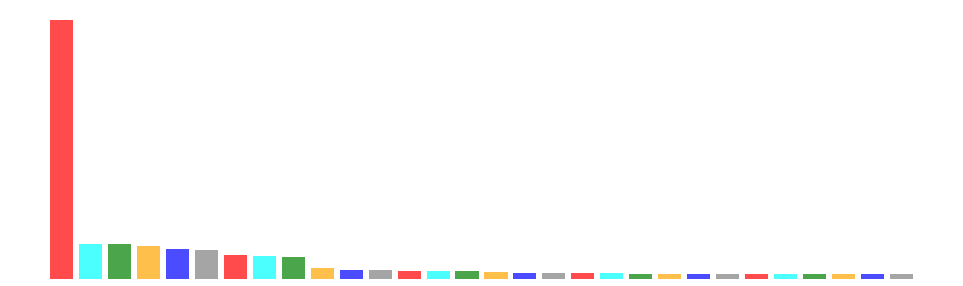

In [12]:
plt.bar(
    height=top_category,
    x=top_category.index.array,
    color=["red", "cyan", "green", "orange", "blue", "grey"],
    alpha=0.7,
)
plt.axis("off")
plt.show()

## Purchases

When the event_type is "purchase", what item do customers buy?

Try using `'event_type' == 'purchase'` and drop empty rows to assess which categories customers buy.

In [13]:
purchase = df.loc[df['event_type'] == 'purchase']
purchase = purchase.dropna(axis=0)
purchase.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
168,2019-11-01 00:01:04 UTC,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d
707,2019-11-01 00:04:51 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,562958505,0f039697-fedc-40fa-8830-39c1a024351d
939,2019-11-01 00:06:33 UTC,purchase,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e
942,2019-11-01 00:06:34 UTC,purchase,5800823,2053013553945772349,electronics.audio.subwoofer,nakamichi,123.56,514166940,8ef5214a-86ad-4d0b-8df3-4280dd411b47
1107,2019-11-01 00:07:38 UTC,purchase,30000218,2127425436764865054,construction.tools.welding,magnetta,254.78,515240495,0253151d-5c84-4809-ba02-38ac405494e1


## What brands do the customers buy?
Try grouping by brand and sorting the values by the brand name.

In [14]:
brands = purchase.groupby("brand")['brand'].agg(['count'])
brands = brands.sort_values("count", ascending =False)
brands

,count
brand,
samsung,198670
apple,165681
xiaomi,57909
huawei,23466
oppo,15080
...,...
kehan,1
kef,1
karapuz,1


In [15]:
del d  # free memory

# Modeling: predict at the time of addition to a shopping cart if the user will purchase a given product or not

### Feature engineering

The goal of this modeling is to predict if the user will purchase a product or not when they add the product to the cart. This is called `cart abandonment` if the user does not purchase.

First, reconstruct and restructure the data to feed into the machine learning model. For this use case, target only the data for which customers have "put" the product into the cart. The relevant `event_type`s are thus "cart" and "purchase".

Create these new features in the training data set:
- `activity_count`: number of activity in that session
- `category_level1`: category
- `category_level2`: sub-category --> split on the "." in the category name
- `weekday`: weekday of the event --> convert `event_time` to a datetime object, then use `pandas.Timestamp.weekday`
- `is_purchased`: whether the is purchased after being put in the cart, this will be the categorical output.

Make sure to de-dup any record.

**Prepare a dataframe for counting activity in the session**

In [16]:
# your code
# first just eliminate the records where event_type = "view" and drop NA values and duplicates

df_targets = df.loc[df["event_type"].isin(["cart", "purchase"])].drop_duplicates(
    subset=["event_type", "product_id", "price", "user_id", "user_session"]
)

cart_purchase_users = df.loc[
    df["event_type"].isin(["cart", "purchase"])
].drop_duplicates(subset=["user_id"])
cart_purchase_users.dropna(how="any", inplace=True)


cart_purchase_users_all_activity = df.loc[
    df["user_id"].isin(cart_purchase_users["user_id"])
]
cart_purchase_users

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
40,2019-11-01 00:00:14 UTC,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.09,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a
168,2019-11-01 00:01:04 UTC,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d
502,2019-11-01 00:03:24 UTC,cart,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e
537,2019-11-01 00:03:39 UTC,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.47,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e
707,2019-11-01 00:04:51 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,562958505,0f039697-fedc-40fa-8830-39c1a024351d
...,...,...,...,...,...,...,...,...,...
67501311,2019-11-30 23:55:04 UTC,cart,1005130,2053013555631882655,electronics.smartphone,apple,1437.02,515582054,829c20b5-696e-4a8a-8a9f-171014a3ecbe
67501367,2019-11-30 23:55:28 UTC,cart,1005105,2053013555631882655,electronics.smartphone,apple,1302.48,566460317,ad056b61-8691-aa65-0fb7-526fc67294f9
67501558,2019-11-30 23:56:57 UTC,cart,1005212,2053013555631882655,electronics.smartphone,samsung,169.09,557794415,068b0939-1d19-4289-90d8-bb0ee2a3547a
67501563,2019-11-30 23:57:01 UTC,cart,3701005,2053013565983425517,appliances.environment.vacuum,philips,308.86,531607492,368ddc8b-5db9-40fb-b7ff-b6582a1192c0


In [17]:
# now you get the number of activities by user session

activity_in_session = (
    cart_purchase_users_all_activity.groupby(["user_session"])["event_type"]
    .count()
    .reset_index()
)
activity_in_session = activity_in_session.rename(
    columns={"event_type": "activity_count"}
)
df_targets = cart_purchase_users_all_activity.copy()
activity_in_session

,user_session,activity_count
0,0000189b-6d2d-45bc-a65c-3a9d94e330a4,1
1,00001a36-7f5a-4c05-a52b-e9935de5331e,1
2,0000264c-75d2-4049-ab5d-93e6dd64650d,2
3,00002e0a-8b74-4c72-bb5a-99e04fa264da,4
4,00002ea0-6a36-47a9-acc9-5b0024c586f9,14
...,...,...
4470929,fffff038-a8d6-4c8a-9bf3-afe71b52733a,10
4470930,fffff7d0-c21e-4a82-83f1-67685ce6ed1c,3
4470931,fffff826-edc8-4d19-9dd7-936ef133bc89,1
4470932,fffffbbe-9f76-403b-b17c-e7c68c48ea1c,4


In [18]:
# create the two new columns for the category levels 1 and 2

df_targets["category_level1"] = (
    df_targets["category_code"].str.split(".", expand=True)[0].astype("category")
)
df_targets["category_level2"] = (
    df_targets["category_code"].str.split(".", expand=True)[1].astype("category")
)

df_targets

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_level1,category_level2
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,NaN,NaN
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,appliances,kitchen
9,2019-11-01 00:00:02 UTC,view,1004258,2053013555631882655,electronics.smartphone,apple,732.07,532647354,d2d3d2c6-631d-489e-9fb5-06f340b85be0,electronics,smartphone
14,2019-11-01 00:00:05 UTC,view,4600658,2053013563944993659,appliances.kitchen.dishwasher,samsung,411.83,526595547,aab33a9a-29c3-4d50-84c1-8a2bc9256104,appliances,kitchen
26,2019-11-01 00:00:09 UTC,view,17501048,2053013558752445019,NaN,eveline,7.59,515849878,31e80b9c-e5b3-437b-9112-c2a110e5c38a,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
67501963,2019-11-30 23:59:53 UTC,view,31500157,2053013558031024687,NaN,luminarc,51.45,549777277,1e0bc18b-93c7-430d-80d8-80134094339b,NaN,NaN
67501965,2019-11-30 23:59:53 UTC,view,4804294,2053013554658804075,electronics.audio.headphone,meizu,64.09,513558661,378e7ed4-649a-4302-b917-b953da5ee801,electronics,audio
67501973,2019-11-30 23:59:57 UTC,view,10502879,2053013553199186187,NaN,NaN,29.60,514007176,941ff09f-c5da-49dd-8501-70c950202a4a,NaN,NaN
67501976,2019-11-30 23:59:59 UTC,view,1004833,2053013555631882655,electronics.smartphone,samsung,167.03,557794415,6fecf566-ebb0-4e70-a243-cdc13ce044cb,electronics,smartphone


In [19]:
# Change the event_time to a timestamp
df_targets['time_stamp'] = pd.to_datetime(df_targets['event_time'])


In [20]:
# Use pandas.dt.dayofweek to get the day of the week
df_targets["weekday"] = df_targets['time_stamp'].dt.dayofweek
df_targets

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_level1,category_level2,time_stamp,weekday
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,NaN,NaN,2019-11-01 00:00:01+00:00,4
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,appliances,kitchen,2019-11-01 00:00:01+00:00,4
9,2019-11-01 00:00:02 UTC,view,1004258,2053013555631882655,electronics.smartphone,apple,732.07,532647354,d2d3d2c6-631d-489e-9fb5-06f340b85be0,electronics,smartphone,2019-11-01 00:00:02+00:00,4
14,2019-11-01 00:00:05 UTC,view,4600658,2053013563944993659,appliances.kitchen.dishwasher,samsung,411.83,526595547,aab33a9a-29c3-4d50-84c1-8a2bc9256104,appliances,kitchen,2019-11-01 00:00:05+00:00,4
26,2019-11-01 00:00:09 UTC,view,17501048,2053013558752445019,NaN,eveline,7.59,515849878,31e80b9c-e5b3-437b-9112-c2a110e5c38a,NaN,NaN,2019-11-01 00:00:09+00:00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67501963,2019-11-30 23:59:53 UTC,view,31500157,2053013558031024687,NaN,luminarc,51.45,549777277,1e0bc18b-93c7-430d-80d8-80134094339b,NaN,NaN,2019-11-30 23:59:53+00:00,5
67501965,2019-11-30 23:59:53 UTC,view,4804294,2053013554658804075,electronics.audio.headphone,meizu,64.09,513558661,378e7ed4-649a-4302-b917-b953da5ee801,electronics,audio,2019-11-30 23:59:53+00:00,5
67501973,2019-11-30 23:59:57 UTC,view,10502879,2053013553199186187,NaN,NaN,29.60,514007176,941ff09f-c5da-49dd-8501-70c950202a4a,NaN,NaN,2019-11-30 23:59:57+00:00,5
67501976,2019-11-30 23:59:59 UTC,view,1004833,2053013555631882655,electronics.smartphone,samsung,167.03,557794415,6fecf566-ebb0-4e70-a243-cdc13ce044cb,electronics,smartphone,2019-11-30 23:59:59+00:00,5


In [21]:
# add the is_purchased feature
df_targets['is_purchased'] = np.where(df_targets['event_type'] == "purchase", 1, 0)
df_targets["is_purchased"] = df_targets.groupby(["user_session", "product_id"])[
    "is_purchased"
].transform("max")

In [22]:
df_targets = df_targets.merge(activity_in_session, on="user_session", how="left")


### Save new data structure if desired

In [23]:
#df_targets.to_csv('training_data.csv')

In [32]:
df_targets = pd.read_csv("training_data.csv")

In [33]:
df_targets.dropna(inplace=True)

In [24]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26749090 entries, 0 to 26749089
Data columns (total 15 columns):
 #   Column           Dtype              
---  ------           -----              
 0   event_time       object             
 1   event_type       object             
 2   product_id       int64              
 3   category_id      int64              
 4   category_code    object             
 5   brand            object             
 6   price            float64            
 7   user_id          int64              
 8   user_session     object             
 9   category_level1  category           
 10  category_level2  category           
 11  time_stamp       datetime64[ns, UTC]
 12  weekday          int64              
 13  is_purchased     float64            
 14  activity_count   float64            
dtypes: category(2), datetime64[ns, UTC](1), float64(3), int64(4), object(5)
memory usage: 2.8+ GB


In [34]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

## Resampling training set

In [35]:
is_purcahase_set = df_targets[df_targets["is_purchased"] == 1]
is_purcahase_set.shape[0]

2701965

In [36]:
not_purcahase_set = df_targets[df_targets["is_purchased"] == 0]
not_purcahase_set.shape[0]

18281637

In [37]:
n_samples = 500000
is_purchase_downsampled = resample(
    is_purcahase_set, replace=False, n_samples=n_samples, random_state=27
)
not_purcahase_set_downsampled = resample(
    not_purcahase_set, replace=False, n_samples=n_samples, random_state=27
)

In [38]:
downsampled = pd.concat([is_purchase_downsampled, not_purcahase_set_downsampled])
downsampled["is_purchased"].value_counts()

1.0    500000
0.0    500000
Name: is_purchased, dtype: int64

In [39]:
# select the brand, price, weekday, category_level1, cateogry_level2, and activity_count features

features = downsampled.loc[:, ["brand", "price", "weekday", "category_level1", "category_level2", "activity_count"],]

In [ ]:
features['brand'].apply(type).unique()

## Encode categorical variables

In [40]:
features.loc[:, "brand"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "brand"].copy()
)
features.loc[:, "weekday"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "weekday"].copy()
)
features.loc[:, "category_level1"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "category_level1"].copy()
)
features.loc[:, "category_level2"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "category_level2"].copy()
)

is_purchased = LabelEncoder().fit_transform(downsampled["is_purchased"])
features.head()

,brand,price,weekday,category_level1,category_level2,activity_count
22500018,83,1003.37,5,7,40,7.0
2685089,650,231.19,2,7,40,8.0
26205183,818,231.64,5,4,29,4.0
14226883,1388,226.49,5,2,18,6.0
1697705,1223,321.73,0,2,26,15.0


In [41]:
print(list(features.columns))

['brand', 'price', 'weekday', 'category_level1', 'category_level2', 'activity_count']


## Split the data
Use a test size of 0.3 and a random state of 86 to split the data into test and train subsets

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features, is_purchased, test_size=0.3, random_state=86)

## Train the model
Choose learning rate of 0.1 on XGBClassifier, fit the model, and make predictions on the test set

In [44]:
from xgboost import XGBClassifier

model = XGBClassifier(learning_rate=0.1)
model.fit(X_train, y_train)
# fit the model on the train sets
y_pred = model.predict(X_test)

In [45]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("fbeta:", metrics.fbeta_score(y_test, y_pred, average="weighted", beta=0.5))

Accuracy: 0.69948
Precision: 0.6832219856593985
Recall: 0.7442353317516595
fbeta: 0.6998548934083884


## Feature importance
Plot the feature importance using plot_importance

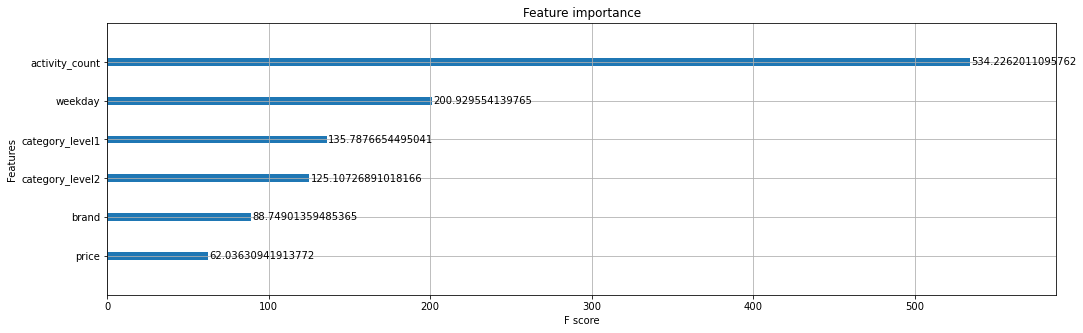

In [46]:
plot_importance(model, max_num_features=10, importance_type="gain")
# plt.rcParams['figure.figsize'] = (40,10)
plt.show()